# Set-up

In [38]:
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

from components import Bilinear

# Model interpretation

## Training the model

In [39]:
# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the dataset for modular addition
p = 113
data_set = np.zeros((p*p, 2*p))
labels = np.zeros((p*p, p))
for number1 in range(p):
  for number2 in range(p):
    data_set[number1*p + number2][number1] = 1
    data_set[number1*p + number2][number2+p] = 1
    labels[number1*p + number2][(number1 + number2) % p] = 1

# shuffle the dataset
shuffle = np.random.permutation(p*p)
data_set = data_set[shuffle]
labels = labels[shuffle]

# divide in train and validation set
train_proportion = 0.8
train_data = data_set[:int(train_proportion*p*p)]
train_labels = labels[:int(train_proportion*p*p)]
val_data = data_set[int(train_proportion*p*p):]
val_labels = labels[int(train_proportion*p*p):]

# convert to tensors
train_data = torch.from_numpy(train_data).float().to(device)
train_labels = torch.from_numpy(train_labels).float().to(device)
val_data = torch.from_numpy(val_data).float().to(device)
val_labels = torch.from_numpy(val_labels).float().to(device)

# define the 1-hidden layer MLP
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.bl1 = Bilinear(input_size, hidden_size, bias=False)
        self.bl2 = Bilinear(hidden_size, output_size, bias=False)
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.u1 = torch.zeros(hidden_size).to(device)
        self.u2 = torch.zeros(hidden_size).to(device)
        self.u3 = torch.zeros(hidden_size).to(device)
        self.w1 = torch.zeros(hidden_size).to(device)
        self.w2 = torch.zeros(hidden_size).to(device)
        self.w3 = torch.zeros(hidden_size).to(device)
        self.s1 = torch.zeros(hidden_size).to(device)
        self.s2 = torch.zeros(hidden_size).to(device)
        self.s3 = torch.zeros(hidden_size).to(device)
        self.o1 = torch.zeros(hidden_size).to(device)
        self.o2 = torch.zeros(hidden_size).to(device)
        self.o3 = torch.zeros(hidden_size).to(device)


    def forward(self, x, val=False):
        pre_relu = self.bl1(x)
        post_relu = torch.nn.functional.relu(pre_relu)
        x = self.bl2(post_relu)
        return x, pre_relu, post_relu


    def cosine(self, x, u, w, s, o):
      return u*torch.cos(x*w*2*np.pi + s) + o


    def forward_with_replaced_weights(self, x, p_l1=0, plot=True, altered_i=None):
        # Cloning the weights before modification
        bl1_weight_original = self.bl1.weight.data.clone()
        bl2_weight_original = self.bl2.weight.data.clone()

        a = torch.argmax(x[:, :113], dim=1).unsqueeze(-1)
        b = torch.argmax(x[:, 113:], dim=1).unsqueeze(-1)

        pre_relu = self.bl1(x)
        if plot:
            plt.matshow(pre_relu[:, 0].cpu().detach().numpy().reshape(113, 113))
            plt.show()

        if not altered_i:
          num_altered_neurons = int(p_l1 * pre_relu.shape[-1])
          altered_i = torch.randperm(pre_relu.shape[-1])[:num_altered_neurons].to(device)


        for i in altered_i:
            # Replace incoming weights of the altered neurons
            self.bl1.weight.data[i, :113] = self.cosine(torch.arange(113).to(device), self.u1[i], self.w1[i], self.s1[i], self.o1[i])
            self.bl1.weight.data[i, 113:] = self.cosine(torch.arange(113).to(device), self.u2[i], self.w2[i], self.s2[i], self.o2[i])

            # Replace outgoing weights of the altered neurons
            self.bl2.weight.data[:, i] = self.cosine(torch.arange(113).to(device), self.u3[i], self.w3[i], self.s3[i], self.o3[i])

        pre_relu = self.bl1(x)  # Re-compute pre_relu with updated weights

        if plot:
            plt.matshow(pre_relu[:, 0].cpu().detach().numpy().reshape(113, 113))
            plt.show()

        post_relu = torch.nn.functional.relu(pre_relu)
        output = self.bl2(post_relu)

        # Restoring the original weights after forward pass
        self.bl1.weight.data = bl1_weight_original
        self.bl2.weight.data = bl2_weight_original

        return output


    def calculate_neuron_properties(self):
        for neuron in range(self.hidden_size):
          weights1 = self.bl1.weight.detach().cpu().numpy()[neuron, :113]
          weights2 = self.bl1.weight.detach().cpu().numpy()[neuron, 113:]
          weights3 = self.bl2.weight.detach().cpu().numpy()[:, neuron]
          x_data = np.arange(self.output_size)
          w1, s1, u1, o1 = self.find_cosine(x_data, weights1)
          w2, s2, u2, o2 = self.find_cosine(x_data, weights2)
          w3, s3, u3, o3 = self.find_cosine(x_data, weights3)
          self.u1[neuron] = torch.tensor(u1, dtype=torch.float32, device=device)
          self.u2[neuron] = torch.tensor(u2, dtype=torch.float32, device=device)
          self.u3[neuron] = torch.tensor(u3, dtype=torch.float32, device=device)
          self.w1[neuron] = torch.tensor(w1, dtype=torch.float32, device=device)
          self.w2[neuron] = torch.tensor(w2, dtype=torch.float32, device=device)
          self.w3[neuron] = torch.tensor(w3, dtype=torch.float32, device=device)
          self.s1[neuron] = torch.tensor(s1, dtype=torch.float32, device=device)
          self.s2[neuron] = torch.tensor(s2, dtype=torch.float32, device=device)
          self.s3[neuron] = torch.tensor(s3, dtype=torch.float32, device=device)
          self.o1[neuron] = torch.tensor(o1)
          self.o2[neuron] = torch.tensor(o2)
          self.o3[neuron] = torch.tensor(o3)


    def find_cosine(self, x_data, y_data):
        # Calculate DFT
        yf = np.fft.fft(y_data)
        xf = np.fft.fftfreq(x_data.size, d=(x_data[1]-x_data[0]))  # assuming x_data is evenly spaced

        # Find the peak frequency
        idx = np.argmax(np.abs(yf[1:yf.size//2]))  # ignore the zero frequency "peak", and only consider the first half of points
        freq = np.abs(xf[idx+1])  # shift index by 1 because we ignored the first point

        # Calculate phase shift
        phase_shift = -np.angle(yf[idx+1])

        # Calculate scale
        scale = 2 * np.abs(yf[idx+1]) / x_data.size

        # Estimate offset
        offset = np.mean(y_data)
        return freq, phase_shift, scale, offset


# define the training loop
def train(model, train_data, train_labels, val_data, val_labels, epochs, batch_size, lr):
    optimzer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.5)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_loss_values = []
    val_loss_values = []
    train_acc_values = []
    val_acc_values = []

    running_train_loss = 0
    print(epochs)
    for epoch in range(epochs):
        model.train()
        correct_train_preds = 0
        total_train_preds = 0
        for batch in range(0, len(train_data), batch_size):
            optimzer.zero_grad()
            output, pre_relu, post_relu = model(train_data[batch:batch+batch_size])
            loss = loss_fn(output, torch.argmax(train_labels[batch:batch+batch_size], axis=1)) #+ 0.0000001*l1_norm
            running_train_loss += loss.item()
            preds = torch.argmax(output, axis=1)
            correct_train_preds += (preds == torch.argmax(train_labels[batch:batch+batch_size], axis=1)).sum().item()
            total_train_preds += len(preds)
            loss.backward()
            optimzer.step()
        model.eval()


        output, _, _ = model(val_data, val=True)
        val_loss = loss_fn(output, torch.argmax(val_labels, axis=1)).item()
        val_preds = torch.argmax(output, axis=1)
        correct_val_preds = (val_preds == torch.argmax(val_labels, axis=1)).sum().item()
        total_val_preds = len(val_preds)
        avg_train_loss = running_train_loss / (len(train_data) / batch_size)
        train_acc = correct_train_preds / total_train_preds
        val_acc = correct_val_preds / total_val_preds
        train_loss_values.append(avg_train_loss)
        val_loss_values.append(val_loss)
        train_acc_values.append(train_acc)
        val_acc_values.append(val_acc)

        print("Epoch: {} | Train loss: {:.2f} | Validation loss: {:.2f} | Train accuracy: {:.2f} | Validation accuracy: {:.2f}".format(epoch, avg_train_loss, val_loss, train_acc, val_acc))

        running_train_loss = 0
    return model, train_loss_values, val_loss_values, train_acc_values, val_acc_values

    def forward_with_replaced_neurons(self, x, p_l1=0, p_l2=0, plot=True):
        a = torch.argmax(x[:, :113], dim=1).unsqueeze(-1)
        b = torch.argmax(x[:, 113:], dim=1).unsqueeze(-1)

        output[:, output_neuron_i] = 0

        for hidden_neuron_i in range(self.hidden_size):
                output[:, output_neuron_i] += post_relu[:, hidden_neuron_i] * \
                                              self.cosine(output_neuron_i, self.u3[hidden_neuron_i], self.w3[hidden_neuron_i], self.s3[hidden_neuron_i], self.o3[hidden_neuron_i])

        return output

# train the model
model = MLP(2*p, 50, p).to(device)
num_epochs = 500
model, train_loss_values, val_loss_values, train_acc_values, val_acc_values = train(model, train_data, train_labels, val_data, val_labels, num_epochs, 128, 0.003)
model.calculate_neuron_properties()

500
Epoch: 0 | Train loss: 4.74 | Validation loss: 4.73 | Train accuracy: 0.01 | Validation accuracy: 0.00
Epoch: 1 | Train loss: 4.74 | Validation loss: 4.73 | Train accuracy: 0.02 | Validation accuracy: 0.00
Epoch: 2 | Train loss: 4.73 | Validation loss: 4.72 | Train accuracy: 0.02 | Validation accuracy: 0.01
Epoch: 3 | Train loss: 4.10 | Validation loss: 3.35 | Train accuracy: 0.07 | Validation accuracy: 0.19
Epoch: 4 | Train loss: 1.47 | Validation loss: 1.16 | Train accuracy: 0.65 | Validation accuracy: 0.69
Epoch: 5 | Train loss: 0.38 | Validation loss: 0.63 | Train accuracy: 0.94 | Validation accuracy: 0.84
Epoch: 6 | Train loss: 0.21 | Validation loss: 0.47 | Train accuracy: 0.99 | Validation accuracy: 0.91
Epoch: 7 | Train loss: 0.17 | Validation loss: 0.39 | Train accuracy: 1.00 | Validation accuracy: 0.94
Epoch: 8 | Train loss: 0.14 | Validation loss: 0.33 | Train accuracy: 1.00 | Validation accuracy: 0.95
Epoch: 9 | Train loss: 0.12 | Validation loss: 0.29 | Train accuracy:

In [40]:
torch.save(model.state_dict(), "model_weights.pth")
# p = 113
# model = MLP(2*p, 100, p).to(device)

# model.load_state_dict(torch.load("model_weights.pth"))
# model.eval()  

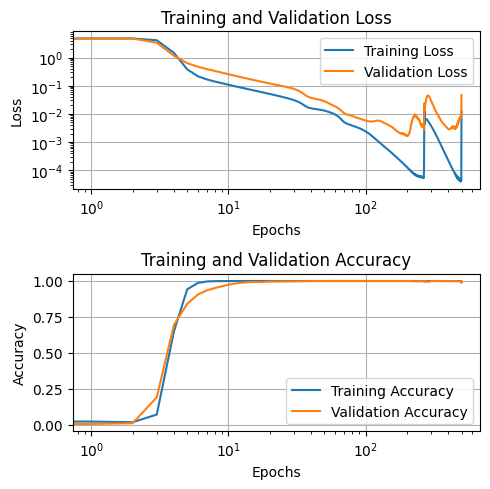

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(5, 5))  # create a new figure with 2 subplots arranged vertically

# Plotting the loss values
ax[0].semilogy(np.arange(num_epochs), train_loss_values, label='Training Loss')
ax[0].semilogy(np.arange(num_epochs), val_loss_values, label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend(loc='upper right')
ax[0].grid(True)
ax[0].set_xscale('log')  # Making the x-axis logarithmic

# Plotting the accuracy values
ax[1].plot(np.arange(num_epochs), train_acc_values, label='Training Accuracy')
ax[1].plot(np.arange(num_epochs), val_acc_values, label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend(loc='lower right')
ax[1].grid(True)
ax[1].set_xscale('log')  # Making the x-axis logarithmic

plt.tight_layout()  # To ensure proper spacing between subplots
plt.show()

## Inspecting the Neurons

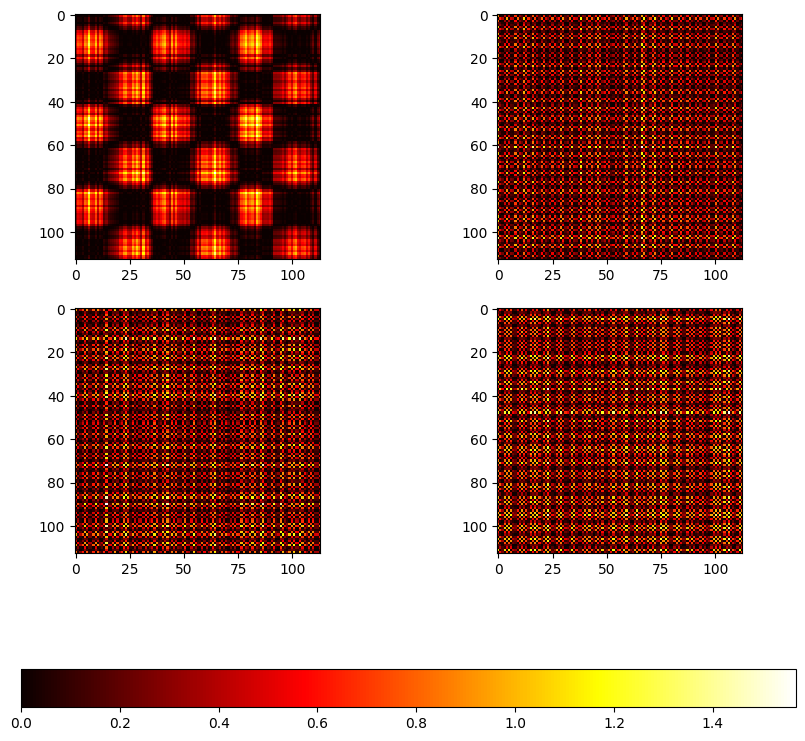

In [46]:
# generate the new data
new_data = np.zeros((p*p, 2*p))
for number1 in range(p):
  for number2 in range(p):
    new_data[number1*p + number2][number1] = 1
    new_data[number1*p + number2][number2+p] = 1

# convert to tensor and move to GPU
new_data_tensor = torch.from_numpy(new_data).float().to(device)

# pass the data through the model and get the post-relu activations
model.eval()
with torch.no_grad():# generate the new data
    _, pre_relu_activations, post_relu_activations = model(new_data_tensor)


# Select four random neuron indices
random_neurons = np.random.choice(50, 4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, neuron in enumerate(random_neurons):
  # get the activations of the neuron
  neuron_activations = post_relu_activations[:, neuron].cpu().numpy()

  # reshape the activations into a 2D array for plotting
  neuron_activations = neuron_activations.reshape(p, p)

  # plot the activations as an image
  ax = axes[i // 2, i % 2]
  im = ax.imshow(neuron_activations, cmap='hot', interpolation='nearest')

# Add a colorbar to the figure, for all subplots
fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
plt.show()


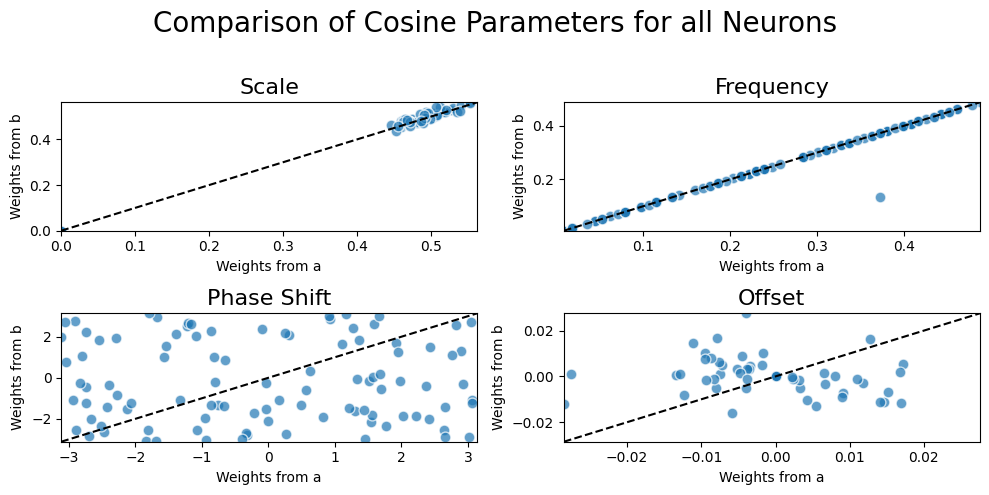

In [ ]:
def find_cosine(x_data, y_data):
  # Calculate DFT
  yf = np.fft.fft(y_data)
  xf = np.fft.fftfreq(x_data.size, d=(x_data[1]-x_data[0]))  # assuming x_data is evenly spaced

  # Find the peak frequency
  idx = np.argmax(np.abs(yf[1:yf.size//2]))  # ignore the zero frequency "peak", and only consider the first half of points
  freq = xf[idx+1]  # shift index by 1 because we ignored the first point

  # Calculate phase shift
  phase_shift = np.angle(yf[idx+1])

  # Calculate scale
  scale = 2 * np.abs(yf[idx+1]) / x_data.size

  # Estimate offset
  offset = np.mean(y_data)

  return scale, freq, phase_shift, offset

weights1 = model.bl1.weight.detach().cpu().numpy()
x_data = np.arange(113)  # fill this in with your x data

# Initialize lists to store parameters
scales, frequencies, phase_shifts, offsets = [], [], [], []
scales2, frequencies2, phase_shifts2, offsets2 = [], [], [], []

# Loop through all neurons
for neuron in range(100):
    y_data = weights1[neuron, :113]  # fill this in with your y data
    scale, frequency, phase_shift, offset = find_cosine(x_data, y_data)
    scales.append(scale)
    frequencies.append(frequency)
    phase_shifts.append(phase_shift)
    offsets.append(offset)

    y_data = weights1[neuron, 113:]  # fill this in with your y data
    scale2, frequency2, phase_shift2, offset2 = find_cosine(x_data, y_data)
    scales2.append(scale2)
    frequencies2.append(frequency2)
    phase_shifts2.append(phase_shift2)
    offsets2.append(offset2)

# Create scatter plots
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

params = [(scales, scales2), (frequencies, frequencies2),
          (phase_shifts, phase_shifts2), (offsets, offsets2)]
titles = ['Scale', 'Frequency', 'Phase Shift', 'Offset']

for ax, param, title in zip(axs.flatten(), params, titles):
    min_val = min(min(param[0]), min(param[1]))
    max_val = max(max(param[0]), max(param[1]))
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.scatter(param[0], param[1], alpha=0.7, edgecolors='w', s=60)
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')  # line X = Y
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Weights from a', fontsize=10)
    ax.set_ylabel('Weights from b', fontsize=10)

# Add overarching title
fig.suptitle('Comparison of Cosine Parameters for all Neurons', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Experiments

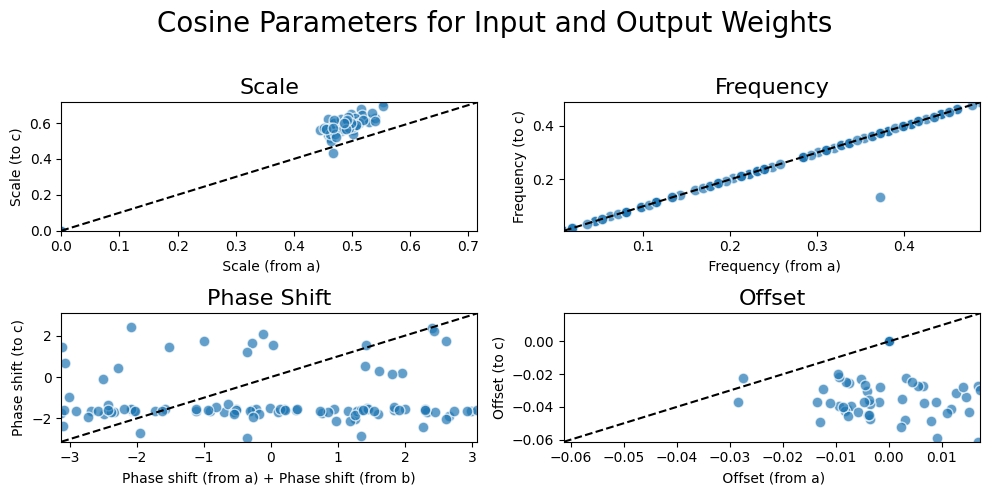

In [ ]:
def calculate_phase(A, B, s1, s2, f):
  result = []
  for i in range(len(s1)):
    if np.abs(s1[i] + s2[i]) < np.pi:
      result.append(s1[i] + s2[i])
    elif s1[i] + s2[i] < -1*np.pi:
      result.append(s1[i] + s2[i]+ 2*np.pi)
    elif s1[i] + s2[i] > np.pi:
      result.append(s1[i] + s2[i] - 2*np.pi)

  return np.asarray(result)

weights1 = model.bl1.weight.detach().cpu().numpy()
weights2 = model.bl2.weight.detach().cpu().numpy()
x_data = np.arange(113)  # fill this in with your x data

# Initialize lists to store parameters
scales, frequencies, phase_shifts, offsets = [], [], [], []
scales2, frequencies2, phase_shifts2, offsets2 = [], [], [], []
scales3, frequencies3, phase_shifts3, offsets3 = [], [], [], []


# Loop through all neurons
for neuron in range(100):
    y_data = weights1[neuron, :113]  # fill this in with your y data
    scale, frequency, phase_shift, offset = find_cosine(x_data, y_data)
    scales.append(scale)
    frequencies.append(frequency)
    phase_shifts.append(phase_shift)
    offsets.append(offset)

    y_data = weights1[neuron, 113:]  # fill this in with your y data
    scale2, frequency2, phase_shift2, offset2 = find_cosine(x_data, y_data)
    scales2.append(scale2)
    frequencies2.append(frequency2)
    phase_shifts2.append(phase_shift2)
    offsets2.append(offset2)

    y_data = weights2[:, neuron]  # fill this in with your y data
    scale3, frequency3, phase_shift3, offset3 = find_cosine(x_data, y_data)
    scales3.append(scale3)
    frequencies3.append(frequency2)
    phase_shifts3.append(phase_shift3)
    offsets3.append(offset3)


# Create scatter plots
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

params = [(np.array(scales), scales3), (frequencies, frequencies3),
          (calculate_phase(np.asarray(scales), np.asarray(scales2), np.asarray(phase_shifts), np.asarray(phase_shifts2), np.asarray(frequencies)), phase_shifts3), (offsets, offsets3)]
titles = ['Scale', 'Frequency', 'Phase Shift', 'Offset']

for ax, param, title in zip(axs.flatten(), params, titles):
    min_val = min(min(param[0]), min(param[1]))
    max_val = max(max(param[0]), max(param[1]))
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.scatter(param[0], param[1], alpha=0.7, edgecolors='w', s=60)
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')  # line X = Y
    ax.set_title(title, fontsize=16)
    if title != 'Phase Shift':
      ax.set_xlabel(f' {title} (from a)', fontsize=10)
      ax.set_ylabel(f'{title} (to c)', fontsize=10)
    else:
      ax.set_xlabel('Phase shift (from a) + Phase shift (from b)', fontsize=10)
      ax.set_ylabel('Phase shift (to c)', fontsize=10)

# Add overarching title
fig.suptitle('Cosine Parameters for Input and Output Weights', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
data_set = np.zeros((p*p, 2*p))
labels = np.zeros((p*p, p))
for number1 in range(p):
  for number2 in range(p):
    data_set[number1*p + number2][number1] = 1
    data_set[number1*p + number2][number2+p] = 1
    labels[number1*p + number2][(number1 + number2) % p] = 1

data = torch.from_numpy(data_set).float().to(device)
labels = torch.from_numpy(labels).float().to(device)


performances = []
losses = []
loss_fn = torch.nn.CrossEntropyLoss()

for i in range(100):
    output = model.forward_with_replaced_weights(data, 0, plot=False, altered_i=[i])
    val_preds = torch.argmax(output, axis=1)
    correct_val_preds = (val_preds == torch.argmax(labels, axis=1)).sum().item()
    total_val_preds = len(val_preds)
    performances.append(correct_val_preds/total_val_preds)
    losses.append(loss_fn(output, labels).item())

indexes = np.argsort(losses)
altered_i = []
performances = []
losses = []
for i in indexes:
    altered_i.append(i)
    output = model.forward_with_replaced_weights(data, 0, plot=False, altered_i=altered_i)
    val_preds = torch.argmax(output, axis=1)
    correct_val_preds = (val_preds == torch.argmax(labels, axis=1)).sum().item()
    total_val_preds = len(val_preds)
    performances.append(correct_val_preds/total_val_preds)
    losses.append(loss_fn(output, labels).item())


plt.plot(np.arange(100), performances)
plt.title("Replacing Neurons weights with their Cosine Approximation")
plt.xlabel("Number of neurons replaced")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()



RuntimeError: The expanded size of the tensor (226) must match the existing size (113) at non-singleton dimension 0.  Target sizes: [226].  Tensor sizes: [113]